In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import tensorflow as tf
tf.__version__

'2.3.1'

In [62]:
np.random.seed(10)
tf.compat.v1.set_random_seed(10)

In [63]:
# Cargo los csv
df_koi = pd.read_csv("./mast-info.csv", skiprows=53)
df_local = pd.read_csv("./unified-lightcurves-local.csv").iloc[:, 1:]
df_global = pd.read_csv("./unified-lightcurves-global.csv").iloc[:, 1:]
df_stellar = pd.read_csv("./unified-stellar-params.csv").iloc[:, 1:]

In [64]:
local_fluxes = df_local.iloc[:,4:]
local_labels = df_local.iloc[:,3]

global_fluxes = df_global.iloc[:,4:]
global_labels = df_global.iloc[:,3]

## Particionado de datos

In [65]:
x_local_train, x_local_test, y_local_train, y_local_test = train_test_split(
    local_fluxes, local_labels, test_size=0.3, random_state=11)
    
x_global_train, x_global_test, y_global_train, y_global_test = train_test_split(
    global_fluxes, global_labels, test_size=0.3, random_state=11)

In [66]:
#Definimos las dimensiones
n_outputs = 1
n_local_timesteps, n_local_features  = x_local_train.shape[0], x_local_train.shape[1]
n_global_timesteps, n_global_features  = x_global_train.shape[0], x_global_train.shape[1]

In [67]:
#Expandimos las dimensiones de train 
x_local_extended_train = np.expand_dims(x_local_train,axis=-1) 
y_local_extended_train = np.array(y_local_train)

x_global_extended_train = np.expand_dims(x_global_train,axis=-1)
y_global_extended_train = np.array(y_global_train)

In [68]:
#Expandimos las dimensiones de test
x_local_extended_test = np.expand_dims(x_local_test,axis=-1)
y_local_extended_test = np.array(y_local_test)

x_global_extended_test = np.expand_dims(x_global_test,axis=-1)
y_global_extended_test = np.array(y_global_test)

## Construcción Red Neuronal

### Red para vistas locales

In [69]:
# first input model
inputLocalView = tf.keras.layers.Input(shape=(n_local_features, 1))
inputLocalView.set_shape([n_local_timesteps, n_local_features, 1]) # 4266 x 101

CL1 = tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation='relu')(inputLocalView)
CL2 = tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation='relu')(CL1)

ML1 = tf.keras.layers.MaxPooling1D(pool_size=7, strides=2)(CL2)

CL3 = tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu')(ML1)
CL4 = tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu')(CL3)

ML2 = tf.keras.layers.MaxPooling1D(pool_size=7, strides=2)(CL4)

flat1 = tf.keras.layers.Flatten()(ML2)

### Red para vistas globales

In [70]:
inputGlobalView = tf.keras.layers.Input(shape=(n_global_features, 1))
inputGlobalView.set_shape([n_global_timesteps, n_global_features, 1])  # 4266 x 1001


CG1 = tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation='relu')(inputGlobalView)
CG2 = tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation='relu')(CG1)

MG1 = tf.keras.layers.MaxPooling1D(pool_size=3, strides=2)(CG2)

CG3 = tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu')(MG1)
CG4 = tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu')(CG3)

MG2 = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(CG4)

CG5 = tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu')(MG2)
CG6 = tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu')(CG5)

MG3 = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(CG6)

CG7 = tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu')(MG3)
CG8 = tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu')(CG7)

MG4 = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(CG8)

CG9 = tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu')(MG4)
CG10 = tf.keras.layers.Conv1D(filters=256, kernel_size=5, activation='relu')(CG9)

MG5 = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(CG10)

flat2 = tf.keras.layers.Flatten()(MG5)

### Unificación de redes y obtencion de estructura

In [71]:
activations = ['tanh',  'sigmoid',  'relu']
optimizers = ['adam', 'adamax']
rrnn = 'gobal-and-local'

full_info = {}

for output_optimizer in optimizers:
    for output_activation in activations:

        full_info.setdefault(output_optimizer,{})
        full_info[output_optimizer].setdefault(output_activation,{})


        print("procesando",output_optimizer, output_activation)
        basefolder = "trainings/" + rrnn + "_" + output_activation + "-" + output_optimizer 
        basepath = basefolder + "/" + rrnn + "_" + output_activation + "-" + output_optimizer

        full_info[output_optimizer][output_activation]["basefolder"] = basefolder

        merge = tf.keras.layers.concatenate([flat1, flat2])

        hidden1 = tf.keras.layers.Dense(256, activation='relu')(merge)
        hidden2 = tf.keras.layers.Dense(256, activation='relu')(hidden1)
        hidden3 = tf.keras.layers.Dense(256, activation='relu')(hidden2)
        hidden4 = tf.keras.layers.Dense(256, activation='relu')(hidden3)

        output = tf.keras.layers.Dense(n_outputs, activation=output_activation)(hidden4)

        model = tf.keras.Model(inputs=[inputLocalView,inputGlobalView], outputs=output)
        model.compile(  loss='binary_crossentropy', 
                        optimizer=output_optimizer, 
                        metrics=['accuracy']
        )




        latest = tf.train.latest_checkpoint(basefolder)
        # print("cargando pesos de", latest)
        model.load_weights(latest)
        
        # print("Predicción")
        y_pred_keras_raw = model.predict([x_local_extended_test,x_global_extended_test])
        y_pred_keras = y_pred_keras_raw.ravel() # flatten as array
        y_pred_keras_standart = (y_pred_keras >= 0.5).astype(np.int)


        accuracy = accuracy_score(y_local_extended_test, y_pred_keras_standart)
        # print("accuracy =", accuracy)

        full_info[output_optimizer][output_activation]["y_pred_keras_raw"] = y_pred_keras_raw
        full_info[output_optimizer][output_activation]["y_pred_keras"] = y_pred_keras
        full_info[output_optimizer][output_activation]["y_pred_keras_standart"] = y_pred_keras_standart
        full_info[output_optimizer][output_activation]["accuracy"] = accuracy

        fp,tp,th = roc_curve(y_local_extended_test, y_pred_keras)
        conf_matrix = confusion_matrix(y_local_extended_test, y_pred_keras_standart)

        full_info[output_optimizer][output_activation]["false_positives"] = fp
        full_info[output_optimizer][output_activation]["true_positives"] = tp
        full_info[output_optimizer][output_activation]["thresholds"] = th
        full_info[output_optimizer][output_activation]["conf_matrix"] = conf_matrix
        
        print("---------------")

print("FIN\n\n\n")

procesando adam tanh
---------------
procesando adam sigmoid
---------------
procesando adam relu
---------------
procesando adamax tanh
---------------
procesando adamax sigmoid
---------------
procesando adamax relu
---------------
FIN





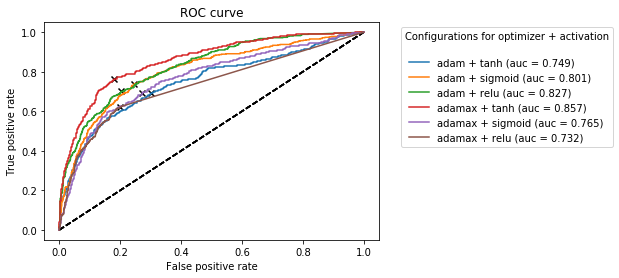

In [72]:
def pintar_roc_curve(fp,tp, optimizer, activation):
    area_under_curve = auc(fp,tp)
    gmeans = np.sqrt(tp * (1-fp))
    ix = np.argmax(gmeans)

    
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(
        fp, 
        tp, 
        label=optimizer + ' + ' + activation + ' (auc = {:.3f})'.format(area_under_curve)
    )
    plt.scatter(fp[ix], tp[ix], marker='x', color='black')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')

    plt.legend( title='Configurations for optimizer + activation\n', 
                bbox_to_anchor=(1.05, 1), 
                loc='upper left'
    )


for output_optimizer in optimizers:
    for output_activation in activations:
        
        pintar_roc_curve(
            full_info[output_optimizer][output_activation]["false_positives"], 
            full_info[output_optimizer][output_activation]["true_positives"],
            output_optimizer, 
            output_activation
        )


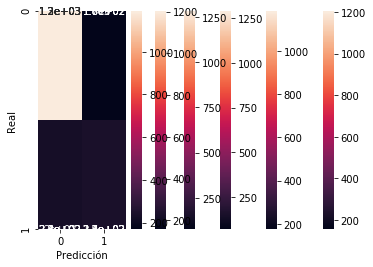

In [73]:
def pintar_matriz_confusion(conf_matx):
    df_cm = pd.DataFrame(conf_matx, index = [i for i in "01"],
                    columns = [i for i in "01"])

    plt.figure(1)
    heat_map = sn.heatmap(
        df_cm, 
        xticklabels=True, 
        yticklabels=True, 
        annot=True, 
        annot_kws = {"ha": 'center'}
    )
    #heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)
    plt.xlabel('Predicción')
    plt.ylabel('Real')



for output_optimizer in optimizers:
    for output_activation in activations:

        pintar_matriz_confusion(
            full_info[output_optimizer][output_activation]["conf_matrix"]
        )
